### See if spikes can decode out "surprise" factor, number of previous corrects on an incorrect trial

In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
import pickle

from models.multinomial_logistic_regressor import MultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer

import torch
from torch import nn

import plotly.express as px
import tensortools as tt

import scipy.stats as sci_stats
import scipy

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])] 
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [5]:
valid_beh["NumPrevCorrects"] = behavioral_utils.get_num_prev_corrects(valid_beh).astype(float)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

/tmp/ipykernel_1665547/3608750788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_beh["NumPrevCorrects"] = behavioral_utils.get_num_prev_corrects(valid_beh).astype(float)


In [6]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

In [7]:
inc_beh = valid_beh[valid_beh.Response == "Incorrect"]
inc_frs = firing_rates[firing_rates.TrialNumber.isin(inc_beh.TrialNumber)]

In [24]:
num_neurons = len(firing_rates.UnitID.unique())
init_params = {"n_inputs": num_neurons, "n_classes": 1}

trainer = Trainer(learning_rate=0.001, max_iter=1000, loss_fn=nn.MSELoss())
wrapped = ModelWrapperLinearRegression()

mode = "SpikeCounts"

# prep data for classification
inputs = inc_frs.rename(columns={mode: "Value"})
labels = inc_beh.rename(columns={"NumPrevCorrects": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=None
)

io_utils.save_model_outputs(
    fs, 
    "num_prev_corrects", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


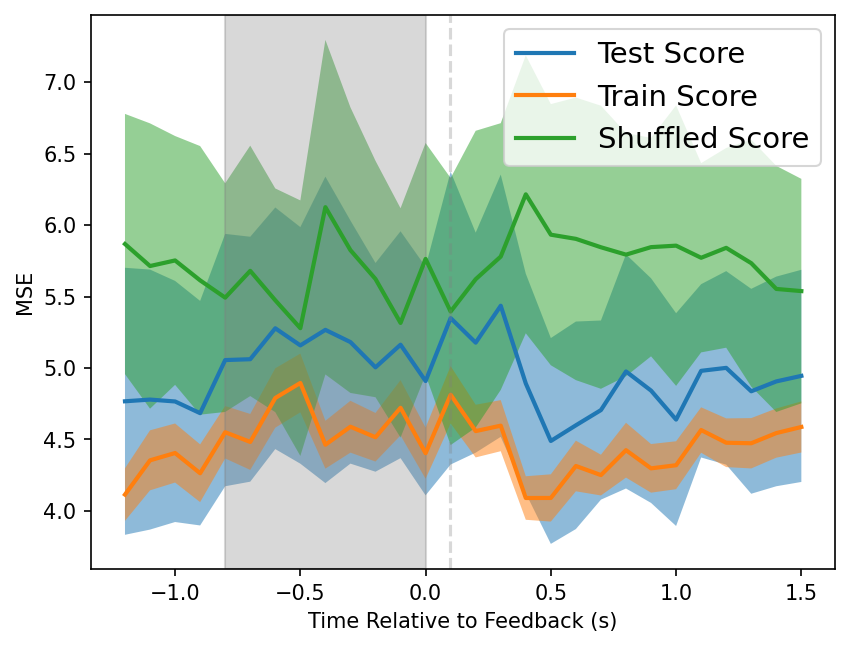

In [25]:
train_score, test_score, shuffled_score, _, _ = io_utils.load_model_outputs(
    fs, 
    "num_prev_corrects", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_score,
    1.3, 1.5, 0.1,
    ax,
    label="Test Score",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    train_score,
    1.3, 1.5, 0.1,
    ax,
    label="Train Score",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_score,
    1.3, 1.5, 0.1,
    ax,
    label="Shuffled Score",
    right_align=True, 
    # color='black'
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("MSE")
ax.legend(prop={'size': 14})

### Look at model at t = 0.4s, on all the data

In [11]:
wrapped = ModelWrapperLinearRegression()
fr_by_for_bin = inputs[np.isclose(inputs.TimeBins, 0.4)]
num_units = len(fr_by_for_bin["UnitID"].unique())
num_trials = len(fr_by_for_bin["TrialNumber"].unique())
sorted_by_trial = fr_by_for_bin.sort_values(by=["TrialNumber", "UnitID"])
inputs_for_bin = sorted_by_trial["Value"].to_numpy().reshape((num_trials, num_units))


In [18]:
model = wrapped.fit(inputs_for_bin, labels["Feature"].values)
predictions = model.predict(inputs_for_bin)

In [22]:
inputs_for_bin.shape

(746, 59)

In [ ]:
inputs_for_bin

Text(0, 0.5, 'Actual Surprise')

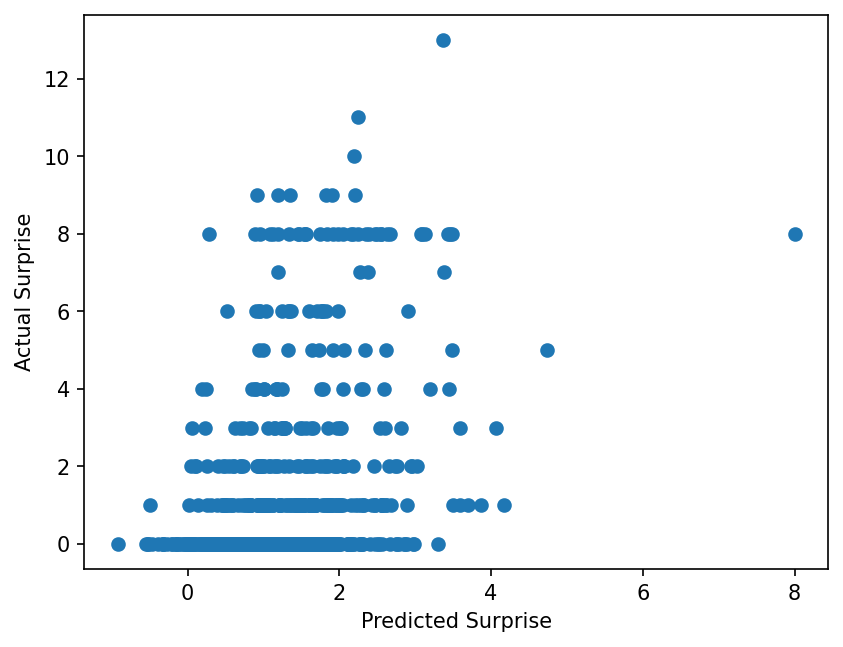

In [20]:
fig, ax = plt.subplots()
ax.scatter(predictions, labels["Feature"].values)
ax.set_xlabel("Predicted Surprise")
ax.set_ylabel("Actual Surprise")

### Try out with sklearn LinearRegression

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


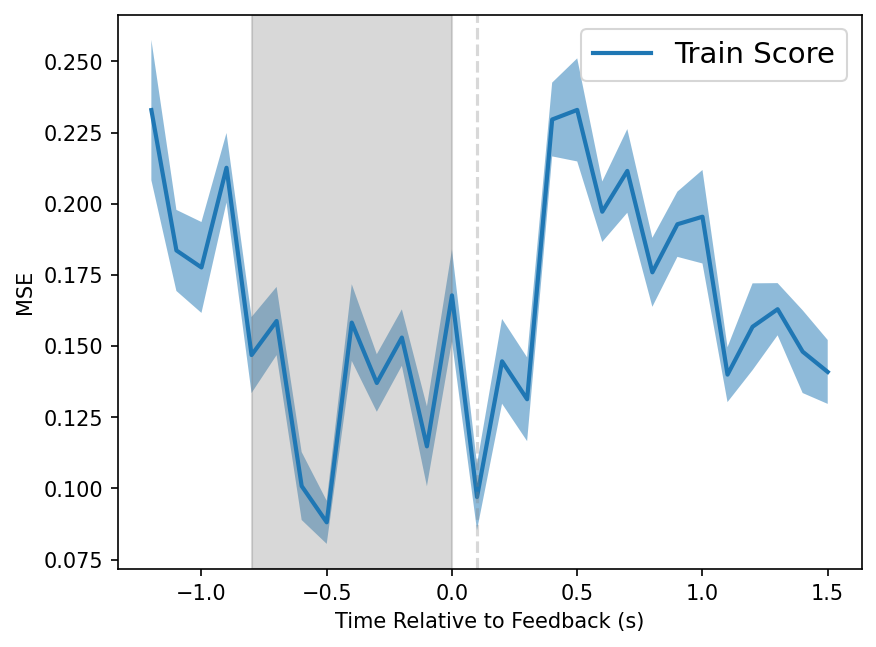

In [22]:
num_neurons = len(firing_rates.UnitID.unique())
init_params = {"n_inputs": num_neurons, "n_classes": 1}

trainer = Trainer(learning_rate=0.001, max_iter=1000, loss_fn=nn.MSELoss())
model = LinearRegression()

mode = "SpikeCounts"

# prep data for classification
inputs = inc_frs.rename(columns={mode: "Value"})
labels = inc_beh.rename(columns={"NumPrevCorrects": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

train, test, shuffled, _, _ = classifier_utils.evaluate_classifiers_by_time_bins(
    model, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=None
)
# outputs = classifier_utils.evaluate_classifiers_by_time_bins(
#     model, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=None
# )

fig, ax = plt.subplots()
# visualization_utils.visualize_accuracy_across_time_bins(
#     test,
#     1.3, 1.5, 0.1,
#     ax,
#     label="Test Score",
#     right_align=True, 
#     add_std=False
#     # color='black'
# )
visualization_utils.visualize_accuracy_across_time_bins(
    train,
    1.3, 1.5, 0.1,
    ax,
    label="Train Score",
    right_align=True, 
    add_std=True
    # color='black'
)
# visualization_utils.visualize_accuracy_across_time_bins(
#     shuffled,
#     1.3, 1.5, 0.1,
#     ax,
#     label="Shuffled Score",
#     right_align=True, 
#     add_std=False
#     # color='black'
# )
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("MSE")
ax.legend(prop={'size': 14})

# io_utils.save_model_outputs(
#     fs, 
#     "num_prev_corrects_sklearn", 
#     f"{pre_interval}_fb_{post_interval}",
#     "random_split",
#     outputs
# )


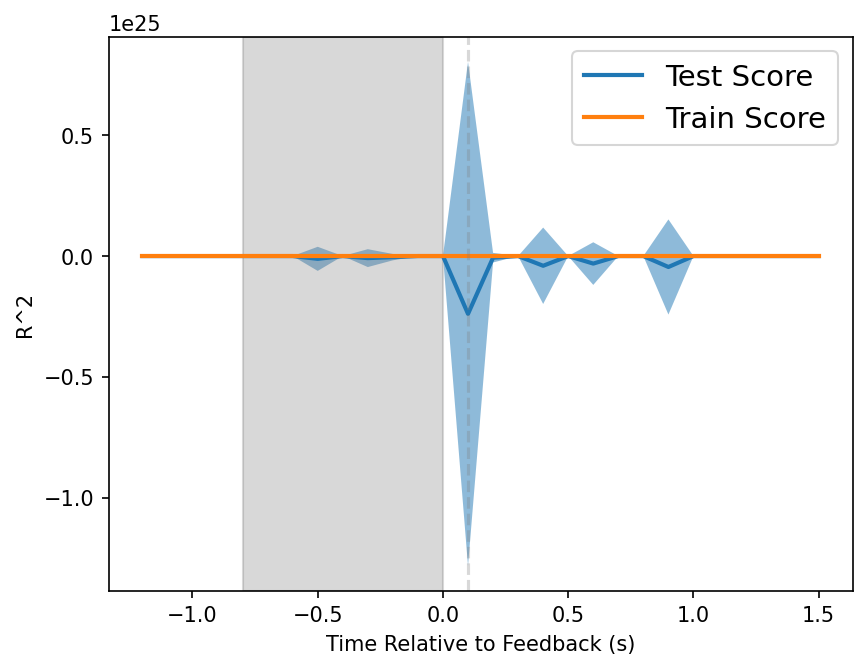

In [21]:
train_score, test_score, shuffled_score, _, _ = io_utils.load_model_outputs(
    fs, 
    "num_prev_corrects_sklearn", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_score,
    1.3, 1.5, 0.1,
    ax,
    label="Test Score",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    train_score,
    1.3, 1.5, 0.1,
    ax,
    label="Train Score",
    right_align=True, 
    # color='black'
)
# visualization_utils.visualize_accuracy_across_time_bins(
#     shuffled_score,
#     1.3, 1.5, 0.1,
#     ax,
#     label="Shuffled Score",
#     right_align=True, 
#     # color='black'
# )
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("R^2")
ax.legend(prop={'size': 14})